In [1]:
#imports
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

# Import existing architectures
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

2.4.1


In [2]:
# Construct a tf.data.Dataset
(train_set, test_set), set_info = tfds.load('oxford_iiit_pet', split=['train','test'], shuffle_files=True, as_supervised=True, with_info=True)

In [3]:
# Function that resizes images to 128x128 and then normalizes from uint8 to float32
def resize_and_normalize(image, label):
  image = tf.image.resize(image, (128, 128))
  return tf.cast(image, tf.float32) / 255., label

In [4]:
# Training pipeline
train_set = train_set.map(resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_set = train_set.cache()
# train_set = train_set.shuffle(set_info.splits['train'].num_examples)
train_set = train_set.shuffle(500)
train_set = train_set.batch(64)
train_set = train_set.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
# Testing pipeline
test_set = test_set.map(
    resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_set = test_set.batch(64)
test_set = test_set.cache()
test_set = test_set.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Load the existing model
existing_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Make it so that the existing model's layers are not trained anymore
for layer in existing_model.layers:
    layer.trainable = False

# Create a custom output for our 37 classes
output = Flatten()(existing_model.output)
output = Dense(37, activation='softmax')(output)

# Create the model
model = Model(existing_model.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

result = model.fit(
    train_set,
    epochs=10,
    validation_data=test_set,
)

Epoch 1/10
 8/58 [===>..........................] - ETA: 1:02 - loss: 3.9763 - sparse_categorical_accuracy: 0.0239

KeyboardInterrupt: 

In [7]:
# Plotting imports
import matplotlib.pyplot as plt

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

In [8]:
# Plot the prediction accuracy
plt.plot(result.history["val_sparse_categorical_accuracy"], label="Val. sparse categorical accuracy")
# plt.plot(result.history["val_loss"], label="Val loss")
plt.legend()

NameError: name 'result' is not defined

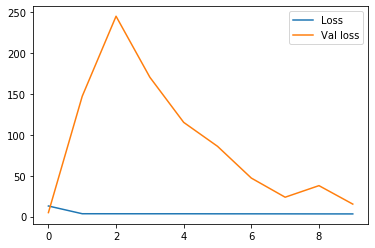

In [9]:
# Plot the loss
plt.plot(result.history["loss"], label="Loss")
plt.plot(result.history["val_loss"], label="Val loss")
plt.legend()